### Load dependencies

In [171]:
import collections
import re
import importlib
import csv

In [161]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [122]:
import iso_lang
import config
import data
import youtube
import client as api_client

In [123]:
importlib.reload(iso_lang)

<module 'iso_lang' from '/Users/jeongmin/Workspace/worldcup-youtube-data-collect/iso_lang.py'>

### Set global variables

In [2]:
COUNTRY_CHANNELS = {
    'global': [
        'fifatv'
    ],
    'france': [
        'beinsportofficiel',
        'ftvsport',
        {'title': 'LCI', 'id': 'UCewhc0fvja891XkpIPGRMxQ'},
        {'title': 'Top Football', 'id': 'UC4iq2jwgACoAiQ6nvk644ZA'},
        {'title': 'BFMTV International', 'id': 'UCFjc3EWFnaV7fGZzlQgiDUA'}
    ],
    'croatia': [
        'sportklub',
        'HRTnovimediji'
    ]
}

In [3]:
ALL_LANGS = ('af,ar,bg,bn,ca,cs,cy,da,de,el,en,es,et,fa,fi,fr,gu,he,hi,hr,hu,'
    + 'id,it,ja,kn,ko,lt,lv,mk,ml,mr,ne,nl,no,pa,pl,pt,ro,ru,sk,sl,so,sq,sv,'
    + 'sw,ta,te,th,tl,tr,uk,ur,vi,zh-cn,zh-tw').split(',')

In [71]:
COLORS = ('#e6194b,#3cb44b,#ffe119,#0082c8,#f58231,#911eb4,#46f0f0,#f032e6,'
    + '#d2f53c,#fabebe,#008080,#e6beff,#aa6e28,#fffac8,#800000,#aaffc3,'
    + '#808000,#ffd8b1,#000080,#808080,#ffffff,#000000').split(',')

### Define data loader functions

In [11]:
def load_videos(channel_id):
    return data.load_jsonlines('%s_videos.jsonlines' % channel_id)

In [12]:
def load_video_statistics(channel_id):
    return data.load_jsonlines('%s_video_statistics.jsonlines' % channel_id)

In [13]:
def load_video_lang_dict(video_id):
    return data.load_json('%s_video_top_comments_languages.json' % video_id)

In [77]:
def load_video_comments(video_id):
    return data.load_json('%s_video_comments.json' % video_id)

### Load data

In [7]:
client = api_client.get_client_with_key()

In [17]:
channel_id = 'fifatv'
videos = load_videos(channel_id)
video_statistics = load_video_statistics(channel_id)

### Analysis

#### Comment language counts

In [65]:
lang_comment_counts = collections.Counter()
for video in videos:
    video_id = video['id']['videoId']
    lang_dict = load_video_lang_dict(video_id)
    for lang in lang_dict.values():
        if lang == 'UNK':
            continue
        lang_comment_counts[lang] += 1

In [66]:
frequent_langs = []
print('Counts of comments per languages')
for i, (lang, count) in enumerate(lang_comment_counts.most_common(15)):
    frequent_langs.append(lang)
    print ('%3d. %2s %8d' % (i + 1, lang, count))

Counts of comments per languages
  1. en   212160
  2. es    17523
  3. pt    15488
  4. fr    10305
  5. de     9467
  6. it     7339
  7. so     6469
  8. ru     5714
  9. id     5610
 10. hr     5105
 11. af     4293
 12. ko     3798
 13. tl     3747
 14. nl     3559
 15. vi     3429


#### Comment count vs. Highlight videos

In [47]:
match_video_dicts = []
for video in videos:
    title = video['snippet']['title']
    video_id = video['id']['videoId']
    m = re.match(r'(.+) v (.+) \- 2018 FIFA World Cup Russia™ \- Match (\d+)', title)
    if m:
        # Get teams.
        teams = [m.group(1), m.group(2)]
        teams.sort()
        
        # Get comments count.
        lang_dict = load_video_lang_dict(video_id)
        comment_count = len(lang_dict)
        lang_dist_dict = collections.Counter([v for v in lang_dict.values() if v != 'UNK'])
        
        video_dict = {
            'video_id': video_id,
            'title': title,
            'teams': teams,
            'match_number': int(m.group(3)),
            'comment_count': comment_count,
            'comment_lang_dist_dict': lang_dist_dict
        }
        match_video_dicts.append(video_dict)

In [59]:
match_video_dicts.sort(key=lambda x: x['match_number'])

In [ ]:
len(match_video_dicts)

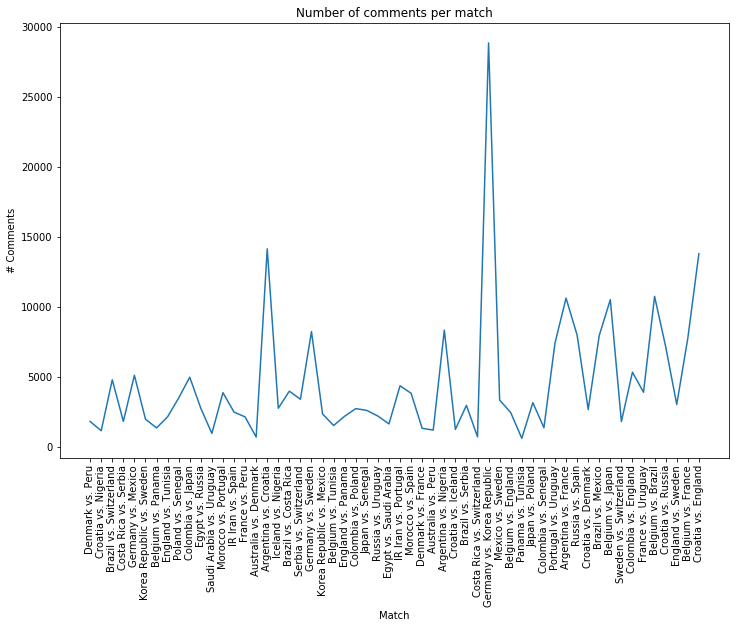

In [62]:
plt.clf()
plt.plot([v['comment_count'] for v in match_video_dicts])
plt.xticks(
    np.arange(len(match_video_dicts)), 
    ['%s vs. %s' % (v['teams'][0], v['teams'][1]) for v in match_video_dicts],
    rotation=90)
plt.ylabel('# Comments')
plt.xlabel('Match')
plt.title('Number of comments per match')
plt.gcf().set_size_inches(12,8)
plt.show()

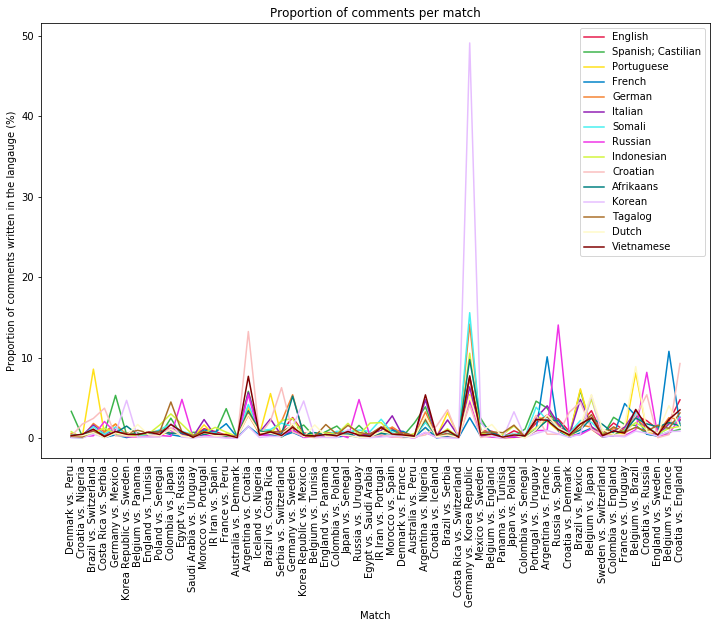

In [130]:
plt.clf()
for i, lang in enumerate(frequent_langs):
    line = plt.plot(
        [(v['comment_lang_dist_dict'][lang] * 100) / lang_comment_counts[lang] for v in match_video_dicts], 
        label=iso_lang.langs[lang]['name'], 
        color=COLORS[i])
plt.legend()
plt.xticks(
    np.arange(len(match_video_dicts)), 
    ['%s vs. %s' % (v['teams'][0], v['teams'][1]) for v in match_video_dicts],
    rotation=90)
plt.ylabel('Proportion of comments written in the langauge (%)')
plt.xlabel('Match')
plt.title('Proportion of comments per match')
plt.gcf().set_size_inches(12,8)
plt.show()

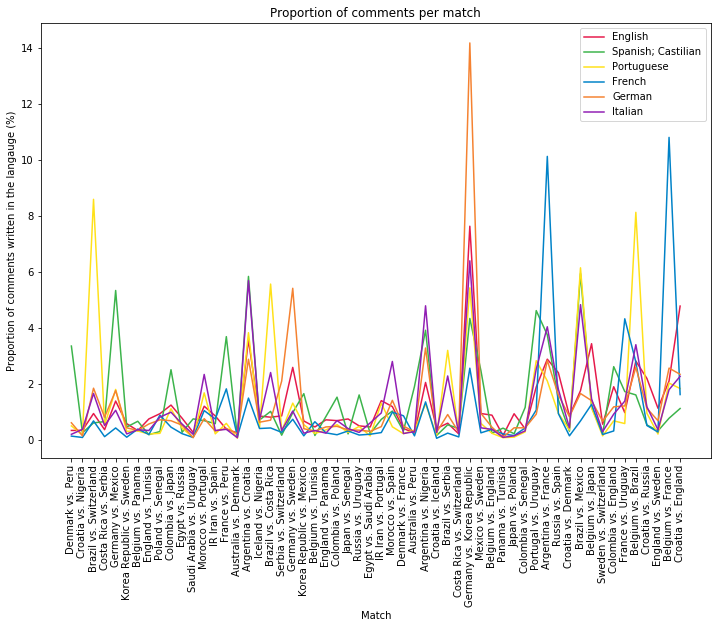

In [129]:
plt.clf()
for i, lang in enumerate(frequent_langs):
    if i > 5:
        break
    line = plt.plot(
        [(v['comment_lang_dist_dict'][lang] * 100) / lang_comment_counts[lang] for v in match_video_dicts], 
        label=iso_lang.langs[lang]['name'], 
        color=COLORS[i])
plt.legend()
plt.xticks(
    np.arange(len(match_video_dicts)), 
    ['%s vs. %s' % (v['teams'][0], v['teams'][1]) for v in match_video_dicts],
    rotation=90)
plt.ylabel('Proportion of comments written in the langauge (%)')
plt.xlabel('Match')
plt.title('Proportion of comments per match')
plt.gcf().set_size_inches(12,8)
plt.show()

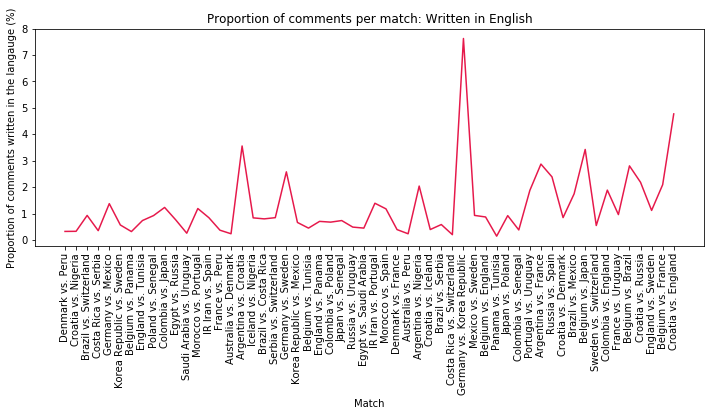

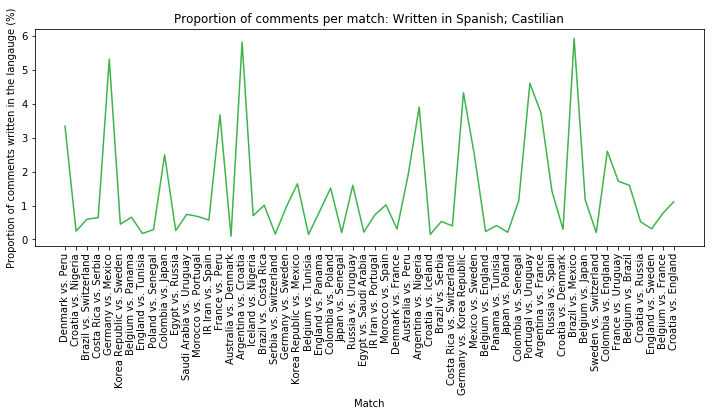

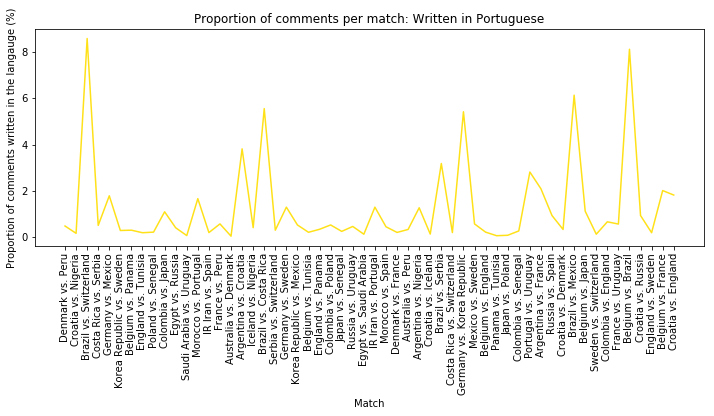

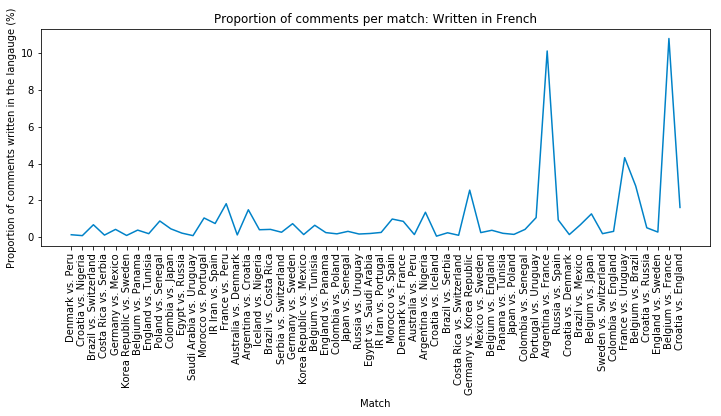

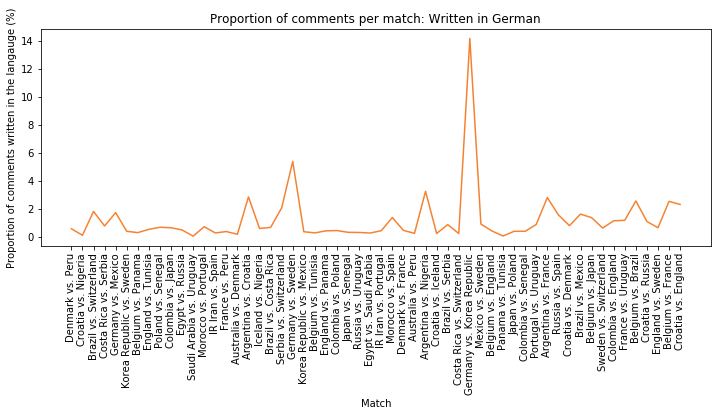

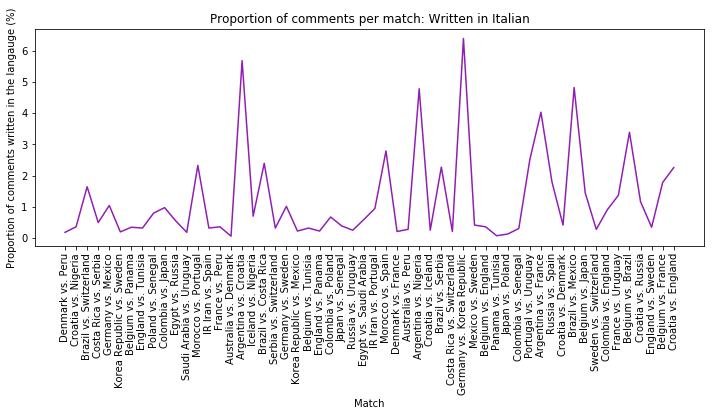

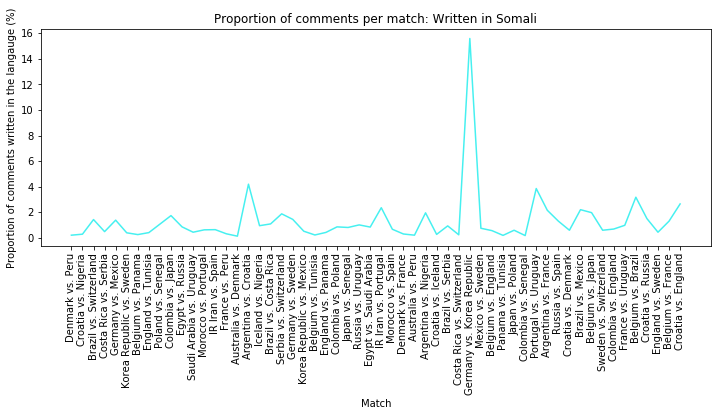

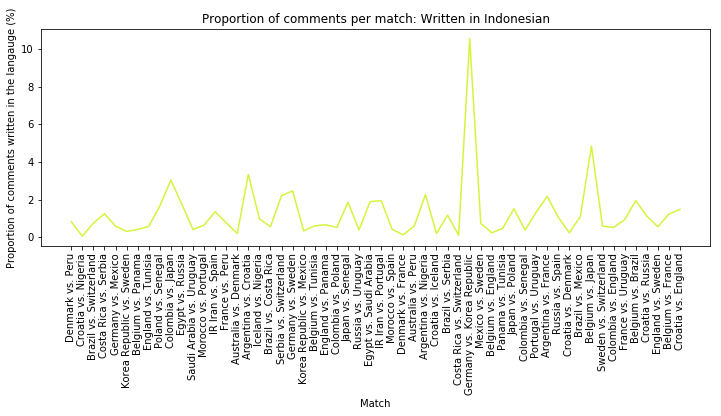

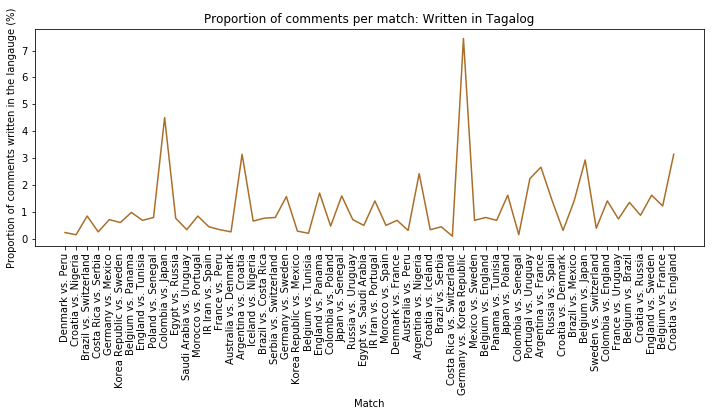

In [153]:
for i, lang in enumerate(frequent_langs):
    if i > 12:
        break
    plt.clf()
    line = plt.plot(
        [(v['comment_lang_dist_dict'][lang] * 100) / lang_comment_counts[lang] for v in match_video_dicts], 
        label=iso_lang.langs[lang]['name'], 
        color=COLORS[i])
    plt.xticks(
        np.arange(len(match_video_dicts)), 
        ['%s vs. %s' % (v['teams'][0], v['teams'][1]) for v in match_video_dicts],
        rotation=90)
    plt.ylabel('Proportion of comments written in the langauge (%)')
    plt.xlabel('Match')
    plt.title('Proportion of comments per match: Written in %s' % iso_lang.langs[lang]['name'])
    plt.gcf().set_size_inches(12,4)
    plt.show()

<Figure size 432x288 with 0 Axes>

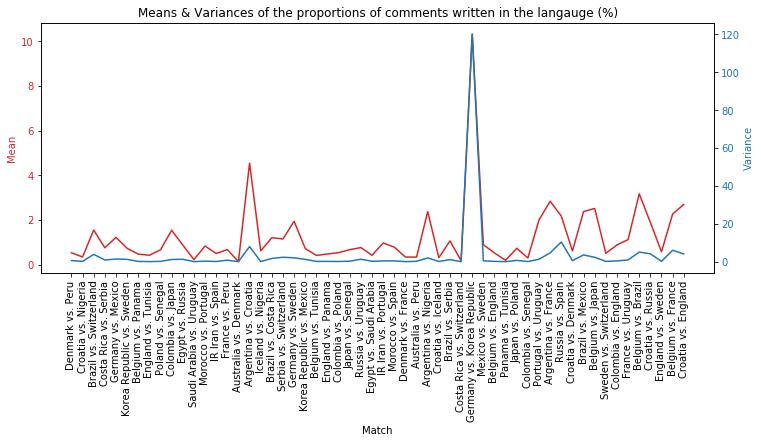

In [149]:
plt.clf()
means = []
variances = []
for v in match_video_dicts:
    lang_dist_dict = v['comment_lang_dist_dict']
    lang_props = []
    for lang in frequent_langs:
        count = lang_dist_dict[lang]
        lang_props.append((count * 100) / lang_comment_counts[lang])
    lang_props_array = np.array(lang_props)
    means.append(lang_props_array.mean())
    variances.append(lang_props_array.var())
    
fig, ax1 = plt.subplots()
    
color = 'tab:red'
ax1.set_xlabel('Match')
ax1.set_ylabel('Mean', color=color)
ax1.plot(means, color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.xticks(
    np.arange(len(match_video_dicts)), 
    ['%s vs. %s' % (v['teams'][0], v['teams'][1]) for v in match_video_dicts],
    rotation=90)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Variance', color=color)  # we already handled the x-label with ax1
ax2.plot(variances, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
    
    

# rax = ax.twinx()
# # s2 = np.sin(2 * np.pi * t)
# ax.plot(means, label='Mean', color='red')
# rax.plot(variances, label='Variances', color='blue')
# plt.legend()

# # rax.ylabel('Proportions of comments written in the langauge (%)')
# plt.xlabel('Match')
plt.title('Means & Variances of the proportions of comments written in the langauge (%)')
fig.set_size_inches(12,10)
plt.show()

#### Users write comments on multiple videos

In [75]:
videos_dict = {}
for video in videos:
    videos_dict[video['id']['videoId']] = video

In [88]:
author_name_dict = {}
author_video_comment_counts = {}
for video_dict in match_video_dicts:
    video_id = video_dict['video_id']
    video = videos_dict[video_id]
    comments_dict = load_video_comments(video_id)
    
    author_comment_counts = collections.Counter()
    for thread in comments_dict['threads']:
        comment = thread['snippet']['topLevelComment']
        author_name = comment['snippet']['authorDisplayName']
        if author_name == '':
            continue
        author_channel_id = comment['snippet']['authorChannelId']['value']
        author_comment_counts[author_channel_id] += 1
        author_name_dict[author_channel_id] = author_name
        
    author_video_comment_counts[video_id] = author_comment_counts

In [91]:
author_total_comment_counts = sum(author_video_comment_counts.values(), collections.Counter())

In [97]:
author_comment_count_array = np.array(list(author_total_comment_counts.values()))

In [100]:
print ('Comment count per author: %.2f±%.2f' % 
       (author_comment_count_array.mean(), author_comment_count_array.std()))

Comment count per author: 1.57±2.18


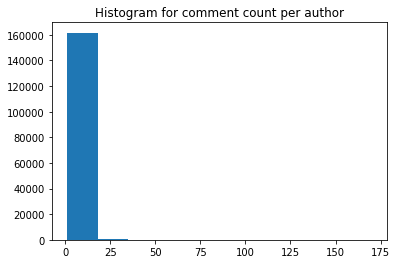

In [110]:
plt.clf()
plt.hist(author_comment_count_array)
plt.title('Histogram for comment count per author')
plt.show()

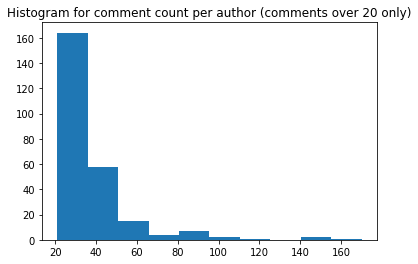

In [128]:
plt.clf()
plt.hist([c for c in author_comment_count_array if c > 20])
plt.title('Histogram for comment count per author (comments over 20 only)')
plt.show()

In [103]:
author_commented_video_counts = sum(
    [collections.Counter({k: 1 for k, v in counts.items()}) for counts in author_video_comment_counts.values()], 
    collections.Counter())

In [104]:
author_commented_video_count_array = np.array(list(author_commented_video_counts.values()))

In [106]:
print ('Commented video count per author: %.2f±%.2f' % 
       (author_commented_video_count_array.mean(), author_commented_video_count_array.std()))

Commented video count per author: 1.46±1.61


In [114]:
plt.clf()
plt.hist(author_commented_video_count_array)
plt.title('Histogram for commented video count per author')
plt.show()

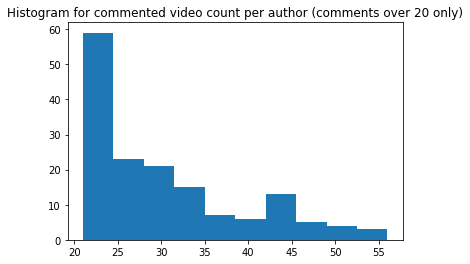

In [127]:
plt.clf()
plt.hist([c for c in author_commented_video_count_array if c > 20])
plt.title('Histogram for commented video count per author (comments over 20 only)')
plt.show()

### Qualitative analysis on comment contents

In [156]:
len(match_video_dicts)

56

In [173]:
commented_video_threshold = 15

In [ ]:
authors_with_many_commented_videos = []
for channel_id, count in author_commented_video_counts.items():
    if count >= commented_video_threshold:
        authors_with_many_commented_videos.append(channel_id)

author_comments_dict = {}
for author_channel_id in tqdm.tqdm_notebook(authors_with_many_commented_videos):
    match_video_comments = []
    display_name = 'Unknown'
    for video_dict in match_video_dicts:
        video_title = '%s vs. %s' % (video_dict['teams'][0], video_dict['teams'][1])
        comments = []
        comment_ids_set = set()
        comments_dict = load_video_comments(video_id)
        for thread in comments_dict['threads']:
            comment = thread['snippet']['topLevelComment']
            author_name = comment['snippet']['authorDisplayName']
            if author_name == '':
                continue
            comment_author_channel_id = comment['snippet']['authorChannelId']['value']
            if comment_author_channel_id == author_channel_id:
                display_name = comment['snippet']['authorDisplayName']
                if comment['id'] not in comment_ids_set:
                    comments.append(comment['snippet']['textDisplay'])
                comment_ids_set.add(comment['id'])
        video_comments_dict = {
            'title': video_title,
            'comments': comments
        }
        match_video_comments.append(video_comments_dict)
    author_dict = {
        'channel_id': author_channel_id,
        'display_name': display_name,
        'match_video_comments': match_video_comments
    }
    author_comments_dict[author_channel_id] = author_dict

In [ ]:
f = open('%s/heavy_commenters.csv' % config.OUT_PATH, 'w')
writer = csv.writer(f, delimiter=',', quotechar='"')
match_video_titles = ['%s vs. %s' % (v['teams'][0], v['teams'][1]) for v in match_video_dicts]
writer.writerow(['Display Name'] + match_video_titles)
for channel_id, author_dict in author_comments_dict.items():
    display_name = author_dict['display_name']
    row = [display_name]
    for video_comments_dict in author_dict['match_video_comments']:
        comment_strings = []
        for comment in video_comments_dict['comments']:
            comment_strings.append('- %s' % comment)
        if comment_strings:
            row.append('\n'.join(comment_strings))
        else:
            row.append('*')
    writer.writerow(row)
f.close()